# Informed vs Uninformed Search

- Uninformed Search: Where each iteration of hyperparameter tuning does **not** learn from the previous iterations.

- Informed Search
![image-2](image-2.png)

**Link to the Official Notes: https://s3.amazonaws.com/assets.datacamp.com/production/course_15167/slides/chapter4.pdf**

# Informed Search: Coarse to Fine

_Start out with a rough, random approach and iteratively refine your search._

The process is:
1. Random Search
2. Find promising areas
3. Grid search in the smaller area
4. Continue until optimal score obtained

Advantages:
- Utilizes the advantages of grid and random search.
    - Wide search to begin with
    - Deeper search **once you know** where a good spot is likely to be

In [5]:
import pandas as pd
import numpy as np 

# Load dataset
credit_card = pd.read_csv('datasets/credit-card-full.csv')
credit_card.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
# Features and Labels
X = credit_card.drop(['ID','default payment next month'], axis=1)
y = credit_card['default payment next month']

# Train-Test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size=0.3,
                                                   random_state=42)

In [5]:
from itertools import product

# Hyperparameter ranges
max_depth_list = list(np.arange(1,65))
min_sample_list = list(np.arange(3,17))
learn_rate_list = list(np.linspace(0.01,1.5,150))

combinations_list = [list(x) for x in product(max_depth_list, min_sample_list, learn_rate_list)]
print(len(combinations_list))

134400


In [10]:
# Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param_distributions = {
    'max_depth': max_depth_list,
    'min_samples_leaf': min_sample_list,
    'learning_rate':learn_rate_list
}

random_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                                  param_distributions= param_distributions,
                                  n_iter=30, 
                                  n_jobs=4,
                                  scoring='accuracy',
                                  refit=True,
                                  cv=3)

# Fit the model
random_search.fit(X_train, y_train)

# Extract cv_results
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,103.263182,8.757755,0.136578,0.006535,9,59,0.48,"{'min_samples_leaf': 9, 'max_depth': 59, 'lear...",0.811571,0.807714,0.802571,0.807286,0.003687,10
1,87.687550,2.921883,0.123501,0.001679,16,52,0.77,"{'min_samples_leaf': 16, 'max_depth': 52, 'lea...",0.801857,0.803429,0.798286,0.801190,0.002152,17
2,79.030035,4.377158,0.156152,0.020425,5,52,1.35,"{'min_samples_leaf': 5, 'max_depth': 52, 'lear...",0.466714,0.793143,0.622571,0.627476,0.133309,30
3,63.136931,1.038640,0.157363,0.025606,5,34,0.42,"{'min_samples_leaf': 5, 'max_depth': 34, 'lear...",0.817571,0.808714,0.809714,0.812000,0.003961,2
4,40.652581,3.776903,0.045242,0.033533,5,14,1.04,"{'min_samples_leaf': 5, 'max_depth': 14, 'lear...",0.769000,0.799429,0.755429,0.774619,0.018397,28


From **total combination of 134400**, _30 combinations were choosen in random_ for randomized search CV which reduced the computational time drastically.

In [11]:
results_df = cv_results[['param_min_samples_leaf','param_max_depth','param_learning_rate','mean_test_score']]
results_df.head()

,param_min_samples_leaf,param_max_depth,param_learning_rate,mean_test_score
0,9,59,0.48,0.807286
1,16,52,0.77,0.801190
2,5,52,1.35,0.627476
3,5,34,0.42,0.812000
4,5,14,1.04,0.774619


In [12]:
# Sort the results_df by accuracy and print the top 10 rows
print(results_df.sort_values(by='mean_test_score', ascending=False).head(10))

   param_min_samples_leaf param_max_depth param_learning_rate  mean_test_score
28                      5              49                0.41         0.812286
3                       5              34                0.42         0.812000
19                     13              35                0.06         0.811619
14                      4              51                0.44         0.810000
22                     10              55                0.29         0.809905
9                       3              29                0.49         0.809619
10                     14              42                0.16         0.809524
6                       3              56                0.49         0.809095
23                     14              38                0.28         0.808333
0                       9              59                0.48         0.807286


In [13]:
# Confirm which hyperparameters were used in this search
print(results_df.columns)

Index(['param_min_samples_leaf', 'param_max_depth', 'param_learning_rate',
       'mean_test_score'],
      dtype='object')


In [28]:
import matplotlib.pyplot as plt

def visualize_hyperparameter(name):
  plt.clf()
  plt.scatter(results_df[name],results_df['mean_test_score'], c=['blue']*30)
  plt.gca().set(xlabel='{}'.format(name), ylabel='accuracy', title='Accuracy for different{}s'.format(name))
  plt.gca().set_ylim([0.5,1])
  plt.show()

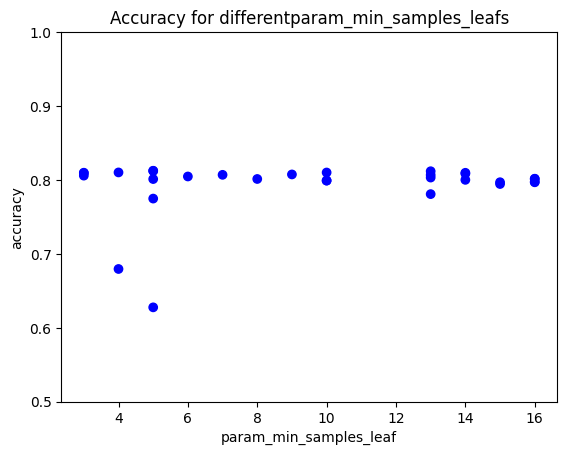

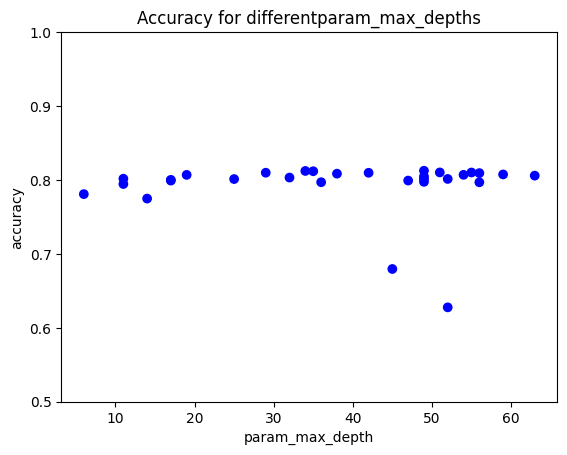

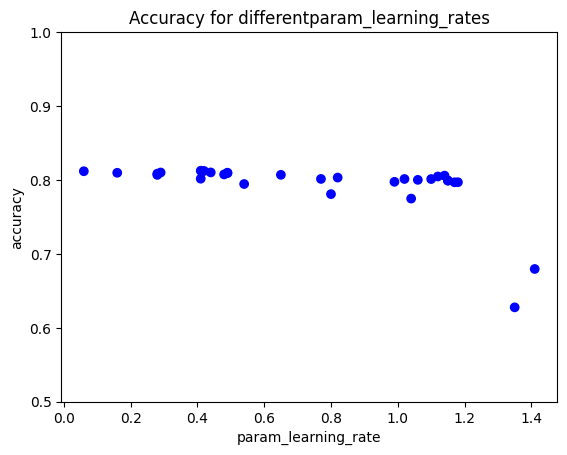

In [29]:
# Call visualize_hyperparameter() with each hyperparameter in turn
visualize_hyperparameter('param_min_samples_leaf')
visualize_hyperparameter('param_max_depth')
visualize_hyperparameter('param_learning_rate')

We found some interesting insights.
- `max_depth` between 25 and 40
- `learn_rate` less than 1.2
- `min_samples_leaf` greater than 13

They all tend to have higher accuracies.

**Note:** This insight can be used to perform further RandomSearchCV or GridSearchCV until optimal score obtains.

# Informed Search: Bayesian Statistics

**Bayes Rule:**
- A statistical method of using **new evidence** to iteratively update our _beliefs_ about some outcome.

**Bayes Rule has the form:**
![image-3](image-3.png)

- LHS = the probability of A, given B has occurred. B is some new evidence.
    - This is known as the 'posterior' 
- RHS is how we calculate this.
- P(A) is the 'prior'. The initial hypothesis about the event. It is different to P(A|B), the P(A|B) isthe probability _given_ new evidence.
- P(B) is the 'marginal likelihood' and it is the probability of observing this new evidence
- P(B|A) is the 'likelihood' which is the probability of observing the evidence, given the event we care about

**A medical example:**
- 5% of people in the general population have a certain disease: P(D)
- 10% of people are predisposed: P(Pre)
- 20% of people with the disease are predisposed: P(Pre|D)

1. What is the probability that any person has the disease?
- P(D)=0.05
This is simply our prior as we have no evidence

2. What is the probability that a predisposed person has the disease?

![image-4](image-4.png)


**In Hyperparameter Tuning**

- Pick a hyperparameter combination
- Build a model
- Get new evidence (the score of the model)
- Update our beliefs and chose better hyperparameters next round

# Bayesian Hyperparameter tuning with Hyperopt

1. Set the Domain: Our Grid (with a bit of a twist)
2. Set the Optimization algorithm (use default TPE)
3. Objective function to minimize: we will use 1-Accuracy because this package tries to minimize not maximize.

**https://hyperopt.github.io/hyperopt/**

In [3]:
pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.3 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [23]:
from hyperopt import hp

# Set up the grid
space = {
    'max_depth': hp.quniform('max_depth',2,10,2),
    'learning_rate':hp.uniform('learning_rate',0.001,0.9)
}

**Notes:** This code demonstrates this using a simple uniform distribution between the min and max values supplied. quniform means uniform but quantized (or binned) by the specified third number.

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Define Objective Function which runs the algorithm

def objective(params):
    
    # Define parameters to test
    params = {'max_depth': int(params['max_depth']),
             'learning_rate': params['learning_rate']}
    
    # Create estimator that takes in the parameters to test
    gbm_clf = GradientBoostingClassifier(n_estimators=100, **params)
    
    # CV the estimator to find the best avg. score and return the avg. loss over the folds
    best_score = cross_val_score(gbm_clf, X_train, y_train,
                                scoring='accuracy',
                                cv=2,
                                n_jobs=4).mean()
    loss = 1 - best_score
    return loss

In [28]:
from hyperopt import fmin, tpe, hp

# Run the algorithm
best_result = fmin(fn=objective, #<-- objective function
                  space=space, #<-- Grid
                  max_evals=17, #<-- Total number of iterations
                  rstate=np.random.default_rng(42), #<-- Random State
                  algo=tpe.suggest, #<-- Opimization algorithm
                  )
print(best_result)

100%|██████████| 17/17 [01:55<00:00,  6.79s/trial, best loss: 0.1782380952380953] 
{'learning_rate': 0.038093061276450534, 'max_depth': 2.0}


# Informed Search: Genetic Algorithms

1.  We can create some models (that have hyperparameter settings)
2.  We pick the best (by our score function)
    - These are the ones that 'survive'

3. We can create new models that are similar to the best ones
4. We add in some randomness so we don't reach a local optimum
5. Repeat until we are happy!

# Genetic Hyperparameter Tuning in TPOT

TPOT is a Python Automated Machine Learning tool that optimizes machine learning **pipelines** using genetic programming.

The key arguments to a TPOT classifier are:
- `generations`: Iterations to run training for.
- `population_size`: The number of models to keep after each iteration.
- `offspring_size`: Number of models to produce in each iteration.
- `mutation_rate`: The proportion of pipelines to apply randomness to. (Produce Random/Diff. Model)
- `crossover_rate`: The proportion of pipelines to breed each iteration. (Produce Similar Model)
- `scoring`: The function to determine the best models.
- `cv`: Cross-validation strategy to use.

In [29]:
from tpot import TPOTClassifier

# Assign the values outlined to the inputs
number_generations = 3
population_size = 4
offspring_size = 3
scoring_function = 'accuracy'

# Create the tpot classifier
tpot_clf = TPOTClassifier(generations=number_generations, population_size=population_size,
                          offspring_size=offspring_size, scoring=scoring_function,
                          verbosity=2, random_state=2, cv=2)

# Fit the classifier to the training data
tpot_clf.fit(X_train, y_train)

# Score on the test set
print(tpot_clf.score(X_test, y_test))

Version 0.11.7 of tpot is outdated. Version 0.12.0 was released Thursday May 25, 2023.


Optimization Progress:   0%|          | 0/13 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8194285714285714

Generation 2 - Current best internal CV score: 0.8194285714285714

Generation 3 - Current best internal CV score: 0.8194285714285714

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=9)
0.82


**Notice how we are not even selecting algorithms or hyperparameters? TPOT does it all!**